In [1]:
!module load cuda

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm, trange

In [3]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data = 'data/big_arpafvg.csv', img_dir = 'data/cut_images'):
        initial_data=pd.read_csv(weather_data)
        initial_data = initial_data.drop(columns=['Temp. min gradi C','Temp. med gradi C','Temp. max gradi C','Vento med km/h','Dir. V. max gradi N'])
        #normalize the data
        for col in initial_data.columns:
            if col != 'giorno' and col != 'mese' and col != 'anno':
                initial_data[col] = (initial_data[col] - initial_data[col].mean()) / initial_data[col].std()
        self.weather_data = initial_data
        self.img_dir = img_dir

    def __getitem__(self, date):
        #get day month year from date in format dd-mm-yyyy
        day, month, year = date.split('_')
        #get from weather data the row with the same date
        weather_data = self.weather_data[(self.weather_data['giorno'] == int(day)) & (self.weather_data['mese'] == int(month)) & (self.weather_data['anno'] == int(year))]
        weather_data = torch.tensor(weather_data.values[0])

        image = os.path.join(self.img_dir, str(date) + '.jpg')  
        image = read_image(image)   
        return [image, weather_data]
    
    def __len__(self):
        return len(self.weather_data)

In [4]:
dataset = WeatherDataset()

In [5]:
#generate a list of strings dd-mm-yyyy from 01-06-2023 to 15-6-2024
from datetime import datetime, timedelta
start_date = datetime.strptime("01_01_2022", "%d_%m_%Y")
end_date = datetime.strptime("15_06_2024", "%d_%m_%Y")
date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
#transform the list of datetime objects in a list of strings in format dd-mm-yyyy
date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]


In [6]:
train_len = int(0.8 * len(date_generated))
test_len = len(date_generated) - train_len
#split the dataset: date_trainset contains the first 80% of the dates, date_testset contains the remaining 20%
date_trainset = date_generated[:train_len]
date_testset = date_generated[train_len:]

In [7]:
(image, weather_data) = dataset[date_generated[np.random.randint(low = 0, high = len(dataset))]]
#print(weather_data)
#print(image)


In [8]:
#MODIFIED CNN

class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3, 3), stride = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p = 0.3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3), stride = 1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), stride = 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), stride = 1)
        self.bn6 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(6154, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, inputs):
        x1, x2 = inputs[0], inputs[1]
        

        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = self.bn4(self.dropout(self.pool(F.leaky_relu(self.conv4(x1)))))
        x1 = self.bn5(self.dropout(self.pool(F.leaky_relu(self.conv5(x1)))))
        x1 = self.bn6(self.dropout(self.pool(F.leaky_relu(self.conv6(x1)))))
        x1 = torch.flatten(x1, start_dim = 1)

        x = torch.cat((x1, x2), dim = 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [9]:
#ORIGINAL CNN
'''
class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p = 0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(6282, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, inputs):
        x1, x2 = inputs[0], inputs[1]
        

        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = torch.flatten(x1, start_dim = 1)

        x = torch.cat((x1, x2), dim = 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        return x
'''

'\nclass DeepWeather(nn.Module):\n    def __init__(self):\n        super(DeepWeather, self).__init__()\n\n        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), stride = 2)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.dropout = nn.Dropout(p = 0.3)\n        self.bn1 = nn.BatchNorm2d(32)\n        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 2)\n        self.bn2 = nn.BatchNorm2d(64)\n        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = 2)\n        self.bn3 = nn.BatchNorm2d(128)\n        self.fc1 = nn.Linear(6282, 1024)\n        self.fc2 = nn.Linear(1024, 128)\n        self.fc3 = nn.Linear(128, 1)\n\n    def forward(self, inputs):\n        x1, x2 = inputs[0], inputs[1]\n        \n\n        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))\n        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))\n        x1 = self.bn3

In [10]:
def train(model, dataset, batch_size,date_trainloader, date_testloader, criterion, optimizer, epochs, first_time = True, num_saved_epochs = 0):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    train_loss_epochs = []
    test_loss_epochs = []
    bar = trange(epochs, desc=f"Epoch ?/?, Train Loss: ?, Test Loss: ?")
    for epoch in bar:
        model.train()
        train_losses = []
        for date_inputs in date_trainloader:
            for date_idx in range(batch_size):
                #print(f'date inputs{date_inputs[date_idx]} and this is the index {date_idx}')
                
                date_input=date_inputs[date_idx]
            

                inputs = dataset[date_input]
                #convert to right type, size and load to device
                inputs = [inputs[0].float().unsqueeze(0).to(device), inputs[1].float().unsqueeze(0).to(device)]

                #increment of 1 day the date_inputs
                date_next_day = date_input.split('_')
                date_next_day = datetime(int(date_next_day[2]), int(date_next_day[1]), int(date_next_day[0])) + timedelta(days = 1)
                date_next_day = date_next_day.strftime("%d_%m_%Y")
                target=dataset[date_next_day][1][3].float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), target)
                train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss_epochs.append(np.mean(train_losses))
        model.eval()
        test_losses = []
        for date_inputs in date_testloader:
            for date_idx in range(batch_size):
                date_input=date_inputs[date_idx]

                inputs = dataset[date_input]
                #convert to right type, size and load to device
                inputs = [inputs[0].float().unsqueeze(0).to(device), inputs[1].float().unsqueeze(0).to(device)]

                #increment of 1 day the date_inputs
                date_next_day = date_input.split('_')
                date_next_day = datetime(int(date_next_day[2]), int(date_next_day[1]), int(date_next_day[0])) + timedelta(days = 1)
                date_next_day = date_next_day.strftime("%d_%m_%Y")
                target=dataset[date_next_day][1][3].float().to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), target)
                test_losses.append(loss.item())
                
        test_loss_epochs.append(np.mean(test_losses))
        bar.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(test_losses)}")
        #if first_time:
            #torch.save(model.state_dict(), f"deepweather_epoch{num_saved_epochs + epoch + 1}.pth")

    return train_loss_epochs, test_loss_epochs

In [11]:
#Uncomment the lines below if you want to train/load a pretrained model
#num_saved_epochs = 50
#model = model.load_state_dict(torch.load(f'weights/epoch_{num_saved_epochs}'))

#Comment the (ONE) line below if you want to train/load a pretrained model.
#!mkdir weights
model = DeepWeather()
batch_size = 4

date_trainloader = DataLoader(date_trainset, batch_size = batch_size, shuffle = False)

date_testloader = DataLoader(date_testset, batch_size = batch_size, shuffle = False)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 10e-6, momentum = 0)

In [12]:
train_losses, test_losses = train(model, dataset, batch_size, date_trainloader, date_testloader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0)

Epoch ?/?, Train Loss: ?, Test Loss: ?:   0%|                                                    | 0/50 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 50/50, Train Loss: 1.0380132316895991, Test Loss: 0.8594794135472228: 100%|███████| 50/50 [04:40<00:00,  5.62s/it]


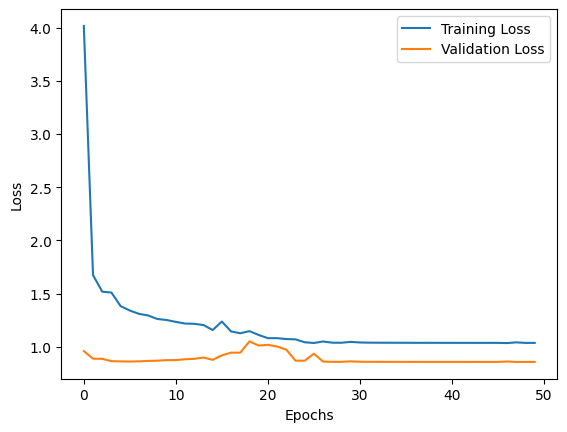

In [13]:
epochs = [epoch for epoch in range(50)]
plt.plot(epochs, train_losses, label = 'Training Loss')
plt.plot(epochs, test_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
def predict(model, date):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    inputs = dataset[date]
    inputs = [inputs[0].float().unsqueeze(0).to(device), inputs[1].float().unsqueeze(0).to(device)]

    outputs = model(inputs)    
    
    return outputs

In [15]:
print(predict(model, '31_12_2023'))
print(dataset['31_12_2023'][1][3])

tensor([[0.0567]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(-0.1916, dtype=torch.float64)


In [16]:
for date in date_testset:
    predicted_rain = predict(model, date)
    #non normalized results
    predicted_rain = predicted_rain 
    print(f"Predicted rain normalized for {date} is {predicted_rain}")
    #while real rain is
    print(f"Real rain normalized  for {date} is {dataset[date][1][3]}")   


Predicted rain normalized for 18_12_2023 is tensor([[0.0565]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real rain normalized  for 18_12_2023 is -0.32236044818546217
Predicted rain normalized for 19_12_2023 is tensor([[0.0565]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real rain normalized  for 19_12_2023 is -0.32236044818546217
Predicted rain normalized for 20_12_2023 is tensor([[0.0566]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real rain normalized  for 20_12_2023 is -0.32236044818546217
Predicted rain normalized for 21_12_2023 is tensor([[0.0561]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real rain normalized  for 21_12_2023 is -0.32236044818546217
Predicted rain normalized for 22_12_2023 is tensor([[0.0563]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real rain normalized  for 22_12_2023 is -0.32236044818546217
Predicted rain normalized for 23_12_2023 is tensor([[0.0564]], device='cuda:0', grad_fn=<AddmmBackward0>)
Real rain normalized  for 23_12_2023 is -0.3223604481854621